In [ ]:
# Purpose: Use K-Fold Cross-Validation and Feature Importance to prune less useful features.
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.metrics import accuracy_score


In [17]:
CLEANED_TRAIN_PATH = "../data/cleaned/train.csv"
CURATED_TRAIN_PATH = "../data/curated/train.csv"


In [20]:
cleaned_df = pd.read_csv(CLEANED_TRAIN_PATH)
curated_df = pd.read_csv(CURATED_TRAIN_PATH)

TARGET_COL = "Survived"

X = cleaned_df.drop(columns=[TARGET_COL, "PassengerId"])  # Drop ID and target
y = cleaned_df[TARGET_COL]


In [22]:

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42)

accuracies = []
feature_importances = []

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    acc = accuracy_score(y_val, preds)
    accuracies.append(acc)

    feature_importances.append(model.feature_importances_)

# Summary
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")

# Combine importances across folds
importances_df = pd.DataFrame(feature_importances, columns=X.columns)
mean_importances = importances_df.mean().sort_values(ascending=False)
display(mean_importances)


Mean Accuracy: 0.8159


Sex           0.255565
Age           0.249545
Fare          0.243427
Pclass        0.079550
SibSp         0.047640
HasCabin      0.045518
Parch         0.039796
Embarked_C    0.015338
Embarked_S    0.015277
Embarked_Q    0.008344
dtype: float64

In [36]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=6)
rfe.fit(X, y)
X_rfe = X.loc[:, rfe.support_]
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())



Selected features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'HasCabin']


In [37]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42)

accuracies = []
feature_importances = []

for train_idx, val_idx in kf.split(X_rfe, y):
    X_train, X_val = X_rfe.iloc[train_idx], X_rfe.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    acc = accuracy_score(y_val, preds)
    accuracies.append(acc)

    feature_importances.append(model.feature_importances_)

# === Summary ===
print(f"Mean Accuracy (top 5 features): {np.mean(accuracies):.4f}")

# Combine importances across folds
importances_df = pd.DataFrame(feature_importances, columns=X_rfe.columns)
mean_importances = importances_df.mean().sort_values(ascending=False)
display(mean_importances)

Mean Accuracy (top 5 features): 0.8271


Fare        0.295924
Age         0.277190
Sex         0.259940
Pclass      0.071633
SibSp       0.048196
HasCabin    0.047117
dtype: float64

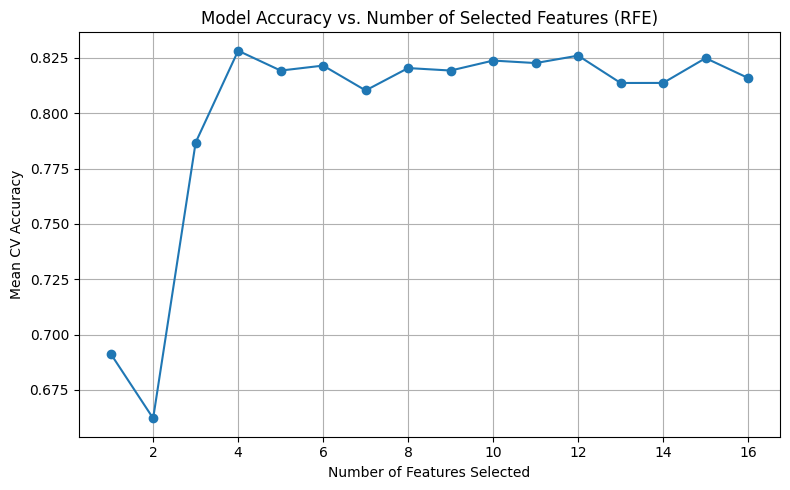

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# === Load data ===
curated_df = pd.read_csv("../data/curated/train.csv")
TARGET_COL = "Survived"

X_full = curated_df.drop(columns=[TARGET_COL, "PassengerId"])
y = curated_df[TARGET_COL]

total_features = X_full.shape[1]

# === Storage ===
n_features_range = list(range(1, total_features + 1))
mean_accuracies = []

for n in n_features_range:
    # Select top-n features
    selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=n)
    selector.fit(X_full, y)
    X_rfe = X_full.loc[:, selector.support_]

    # CV
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accs = []
    for train_idx, val_idx in kf.split(X_rfe, y):
        X_train, X_val = X_rfe.iloc[train_idx], X_rfe.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        accs.append(accuracy_score(y_val, preds))

    mean_accuracies.append(np.mean(accs))

# === Plot ===
plt.figure(figsize=(8, 5))
plt.plot(n_features_range, mean_accuracies, marker='o')
plt.title("Model Accuracy vs. Number of Selected Features (RFE)")
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
